In [8]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import requests
import shutil
import pandas as pd
from collections import OrderedDict
from operator import itemgetter
import geopandas as gpd
import matplotlib as mpl
from shapely import wkt

In [9]:
notebook_root = Path().resolve()
home_folder = rootutils.setup_root(str(notebook_root), indicator=".project-root", pythonpath=True)
data_dir = home_folder / "data"

## County selection analysis

- selection is based on yield frequency and spatial cropland cover
- for each crop, yield frequencies are prethresholded > 1 
- this means 1 of of 5 times (2018-2022), there should be a yield record
- yield frequencies are further summed across all 5 crops 
- if a county has a yield record for all 5 years and all crops,
    - maximum frequency count will be 25
- final counties selected should have 3 or more out of 25 counts
- to reduce overall number of counties and subsequently the data size, 
- counties are further conditioned by the ratio of the number of potential patches 
    - possible within the county to yield frequency
- counties within states with relatively low counties are exempted from deletion

### 1. spatial cropland cover per county

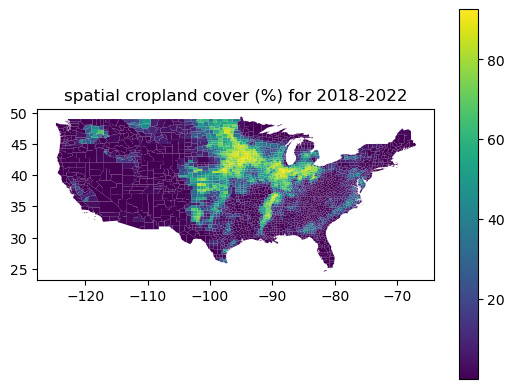

In [10]:
geom_path = os.path.join(data_dir, 'geometry/cb_2021_us_county_500k.csv')
geom = pd.read_csv(geom_path,  dtype={'GEOID': str})
geom['geometry'] = geom['WKT'].apply(wkt.loads)


# load 5 year spatial frequency
spatial_2018 = gpd.read_file(os.path.join(data_dir, 'cropland/cropland_spatial_stats2018_2022/all_land_freq_stats.geojson'))
spatial_2018['cropland_cover_perc'] = spatial_2018['crop_sqkm']/spatial_2018['geom_sqkm'] *100

# remove geometry column
spatial_2018 = spatial_2018.drop(columns=['geometry'])
spatial_2018 = pd.merge(spatial_2018, geom, on='GEOID')
spatial_2018 = gpd.GeoDataFrame(spatial_2018, geometry='geometry')



# Plot the second GeoDataFrame on the second subplot
spatial_2018.plot(column = 'cropland_cover_perc', legend=True)
plt.title('spatial cropland cover (%) for 2018-2022')

plt.show()


### 2. crop yield frequency

In [11]:
preferred_year_start = 2018 
crop_freq_path = os.path.join(data_dir, 'yield/yield_record_frequency{}'.format(preferred_year_start))

corn = gpd.read_file(os.path.join(crop_freq_path, 'CORN_frequency.geojson'), usecols=['GEOID', 'CORN_Count'])
cotton = gpd.read_file(os.path.join(crop_freq_path, 'COTTON_frequency.geojson'), usecols=['GEOID', 'COTTON_Count'])
oats = gpd.read_file(os.path.join(crop_freq_path, 'OATS_frequency.geojson'), usecols=['GEOID', 'OATS_Count'])
soybeans = gpd.read_file(os.path.join(crop_freq_path, 'SOYBEANS_frequency.geojson'), usecols=['GEOID', 'SOYBEANS_Count'])
winterwheat = gpd.read_file(os.path.join(crop_freq_path, 'WINTER_WHEAT_frequency.geojson'), usecols=['GEOID', 'WINTER_WHEAT_Count'])

crop_gdfs = [corn, cotton, oats, soybeans, winterwheat]

/mnt/datastorage/home/adrianhohl/mambaforge/envs/v3/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver GeoJSON does not support open option USECOLS
  return ogr_read(
/mnt/datastorage/home/adrianhohl/mambaforge/envs/v3/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver GeoJSON does not support open option USECOLS
  return ogr_read(
/mnt/datastorage/home/adrianhohl/mambaforge/envs/v3/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver GeoJSON does not support open option USECOLS
  return ogr_read(
/mnt/datastorage/home/adrianhohl/mambaforge/envs/v3/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver GeoJSON does not support open option USECOLS
  return ogr_read(
/mnt/datastorage/home/adrianhohl/mambaforge/envs/v3/lib/python3.10/site-packages/pyogrio/raw.py:196: RuntimeWarning: driver GeoJSON does not support open option USECOLS
  return ogr_read(


### 3. county filtering based on crop yield frequency

In [12]:
def create_yield_frequency(pre_threshold=1, threshold=4, crops_gdf=crop_gdfs):

    # get any df with geoid, geometry
    base_df = crop_gdfs[0][['GEOID', 'geometry']]

    # get geometry column
    gdf_geom = base_df['geometry']

    # for each crop remove counties with N or less freq
    for c in crops_gdf:
        c_df = c[c['Count'] > pre_threshold]
        c_df = c[[x for x in c_df.columns if '_Count' in x] + ['GEOID']].copy()
        base_df = pd.merge(base_df, c_df, on='GEOID', how='left') 

    base_df['Total_Count'] = base_df.filter(like='_Count').sum(axis=1)
    base_df['geometry'] = gdf_geom

    # Set the new geometry column
    base_df = base_df.set_geometry('geometry')

    # filter than general threshold
    base_df = base_df[base_df['Total_Count'] > threshold]
    return base_df[['geometry', 'GEOID', 'Total_Count']]



def generate_counties(pre_threshold=1, freq_threshold=4, cropland_cover = 5, crop_gdfs = crop_gdfs):

    # create cropland frequency
    yield_frequency = create_yield_frequency(pre_threshold, freq_threshold, crop_gdfs)
    # print('yield freq', yield_frequency.shape[0])

    # read spatial crop cover
    spatial_2018 = gpd.read_file(os.path.join(data_dir, 'cropland/cropland_spatial_stats2018_2022/all_land_freq_stats.geojson'))
    spatial_2018['cropland_cover_perc'] = spatial_2018['crop_sqkm']/spatial_2018['geom_sqkm'] *100
    spatial_2018 = spatial_2018.drop(columns=['geometry', 'crop_sqkm'])
    spatial_2018 = spatial_2018[spatial_2018['cropland_cover_perc'] > cropland_cover]
    spatial_2018 = pd.merge(spatial_2018, geom, on='GEOID')
    spatial_2018 = gpd.GeoDataFrame(spatial_2018, geometry='geometry')
    # print('spatial cover', spatial_2018.shape[0])

    # Create a 1x3 subplot layout
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    # Plot the first GeoDataFrame (county frequency thresholded at N) in the first subplot
    yield_frequency.plot(ax=axs[0], column='Total_Count', cmap='coolwarm', legend=True)
    axs[0].set_title('Yield Freq. Threshold {} | Total Counties {}'.format(freq_threshold, yield_frequency.shape[0]))

    # Plot the second GeoDataFrame (crop cover more than N%) in the second subplot
    ## add geometry for plotting and merge with spatial_df
    spatial_2018.plot(ax=axs[1], column='cropland_cover_perc', cmap='coolwarm', legend=True)
    axs[1].set_title('Spatial Cropland Cover > {}% | Total Counties {}'.format(cropland_cover, spatial_2018.shape[0]))

    # # Plot the thrid GeoDataFrame (merger of freq and crop cover)
    spatial_2018 = spatial_2018.drop(columns=['geometry'])
    merged_df = pd.merge(yield_frequency, spatial_2018, on='GEOID')
    merged_df.plot(ax=axs[2], column='Total_Count', cmap='coolwarm', legend=True)
    axs[2].set_title('Freq. {} merged Cover {}% | Total Counties {}'.format(freq_threshold, cropland_cover, merged_df.shape[0]))


    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

    return merged_df
final_counties_3 = generate_counties(pre_threshold =1, freq_threshold=3, cropland_cover = 5, crop_gdfs = crop_gdfs)


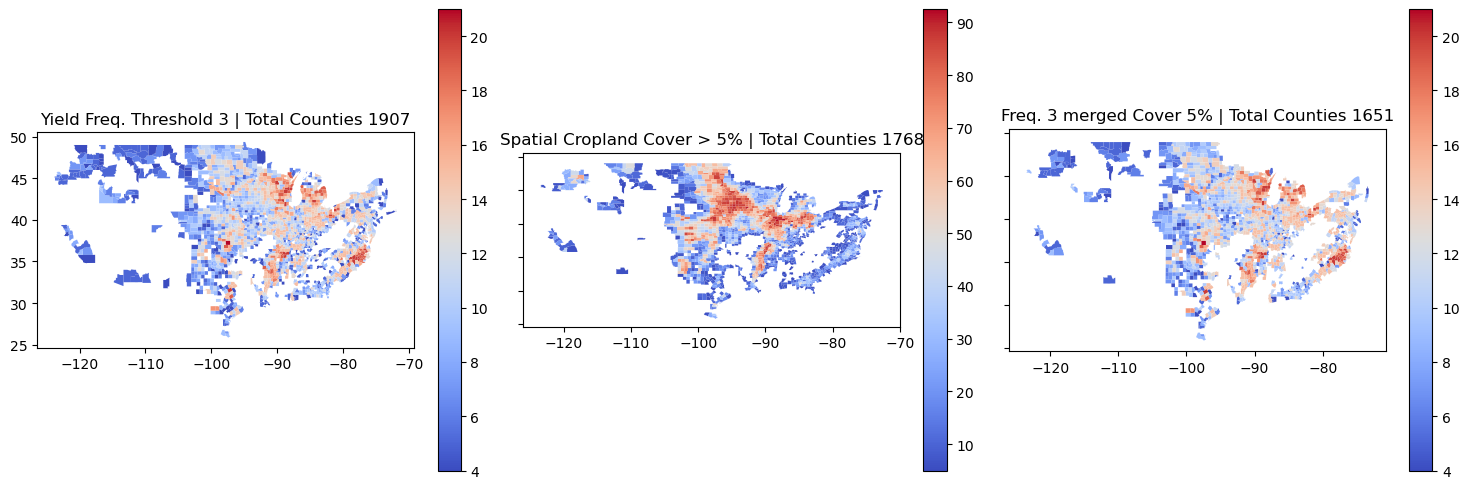

In [13]:
final_counties_3 = generate_counties(pre_threshold =1, freq_threshold=3, cropland_cover = 5, crop_gdfs = crop_gdfs)

### 4. county selection based on yield frequency and patch count

##### patch count analysis

In [14]:
import re

counter_dict = {}
patch_path = os.path.join(data_dir, 'county_list.geojson')

for i in os.listdir(patch_path):
    match = re.search(r'_(\d+)', i)
    geoid = match.group(1)

    patch_geo = gpd.read_file(os.path.join(patch_path, i))
    patch_counter = patch_geo.shape[0]
    counter_dict[geoid] = patch_counter


counter_dict_ord = dict(sorted(counter_dict.items(), key=lambda item: item[1], reverse=True))
patch_df = pd.DataFrame(list(counter_dict_ord.items()), columns=['GEOID', 'patches'])

#### which states have the most counties?

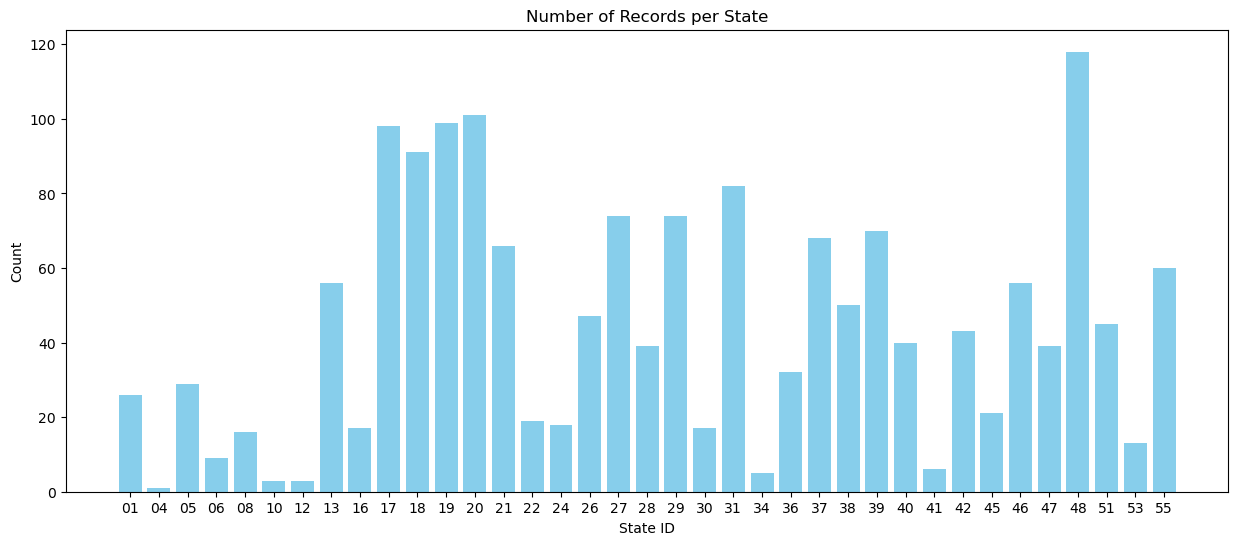

In [15]:
final_counties_3_state_counter =  final_counties_3.copy(deep=True)
final_counties_3_state_counter['STATE'] = final_counties_3['GEOID'].str[:2]
final_counties_3_state_counter = final_counties_3_state_counter.groupby('STATE').size().reset_index(name='count')


# Plot a bar chart
plt.figure(figsize=(15, 6))
plt.bar(final_counties_3_state_counter['STATE'], final_counties_3_state_counter['count'], color='skyblue')
plt.xlabel('State ID')
plt.ylabel('Count')
plt.title('Number of Records per State')
plt.show()

final county size (1527, 4)


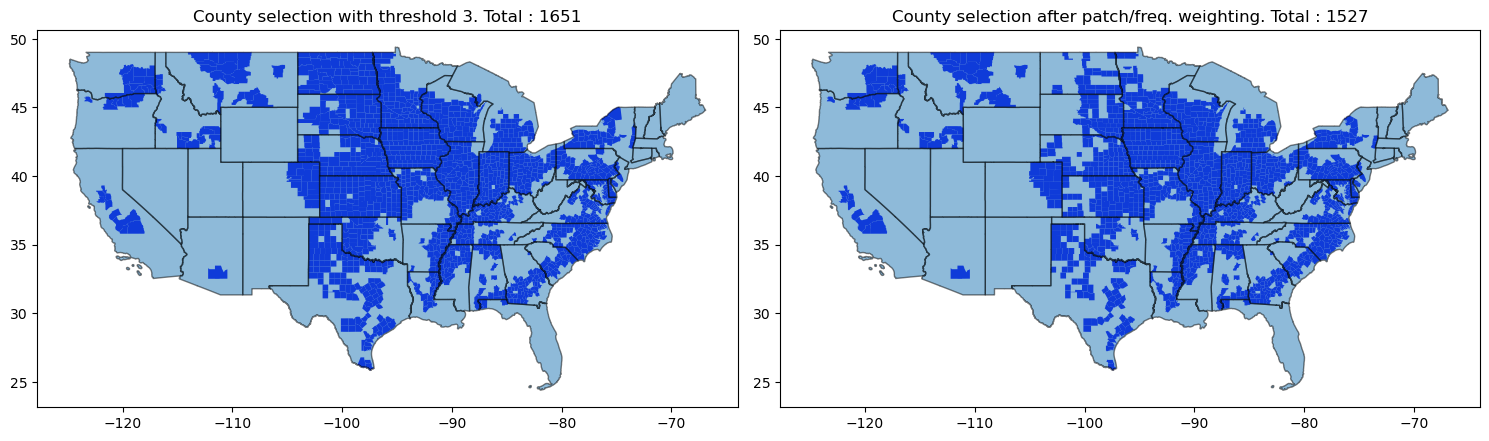

In [16]:
# load state
state = gpd.read_file(os.path.join(home_folder, 'data/shared/geometry/state/tl_2018_us_state_mainland.shp'))

limit = 20 # exclude states with counties less than this limit
metric_threshold = 2 # patch to frequency ratio threshold

target_states = final_counties_3_state_counter[final_counties_3_state_counter['count'] >= limit]
target_states_list = target_states['STATE'].tolist()

# filter counties within high-county states
target_counties = final_counties_3[final_counties_3['GEOID'].
                                   apply(lambda x: any(x.startswith(prefix) 
                                                       for prefix in target_states_list))]

# counties not filtered
def does_not_start_with_any(value, start_list):
    return not any(value.startswith(prefix) for prefix in start_list)
    
non_target_counties = final_counties_3[final_counties_3['GEOID'].
                                       apply(lambda x: does_not_start_with_any(x, target_states_list))]

strategy2 = target_counties.merge(patch_df, on='GEOID', how="inner")
strategy2['metric'] = strategy2['patches'] / strategy2['Total_Count']
strategy2 = strategy2.sort_values(by='metric', ascending=False)

# # activate to plot histogram of patch/freq.
# strategy2['metric'].plot(kind='hist', bins=30, color='skyblue', 
#                          edgecolor='black', title='Histogram of patch/frequency ratio')
# plt.show()



objects_to_keep = strategy2[strategy2['metric'] <= metric_threshold]

# merge with non-target county
final_selection = pd.concat([objects_to_keep[['geometry', 'GEOID', 'geom_sqkm', 'Total_Count']], 
                             non_target_counties[['geometry', 'GEOID', 'geom_sqkm', 'Total_Count']]], 
                             ignore_index=True)
print('final county size', final_selection.shape)


# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first GeoDataFrame on the first subplot
final_counties_3.plot(ax=axes[0], color='blue', marker='o', markersize=5)
state.plot(ax=axes[0], color=None, alpha=0.5, edgecolor='black')
axes[0].set_title('County selection with threshold 3. Total : {}'.format(final_counties_3.shape[0]))

# Plot the second GeoDataFrame on the second subplot
# final_counties_3.plot(ax=axes[1], color='red', marker='o', markersize=5)
final_selection.plot(ax=axes[1], color='blue', marker='o', markersize=5)
state.plot(ax=axes[1], color=None, alpha=0.5, edgecolor='black')
axes[1].set_title('County selection after patch/freq. weighting. Total : {}'.format(final_selection.shape[0]))

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
final_selection.to_file(os.path.join(data_dir, 'cropland/final_counties_5crop_2018/final_counties_yield_th3_merged_cropcover_th5_patchmetric.geojson'))

# Generate subselection for Sentinel-2

In [18]:
# read the selected counties from before
fn = os.path.join(data_dir, 'cropland/final_counties_5crop_2018/final_counties_yield_th3_merged_cropcover_th5_patchmetric.geojson')
gdf = gpd.read_file(fn)
fn2 = os.path.join(data_dir, 'geometry/state/tl_2018_us_state_mainland.shp')
states = gpd.read_file(fn2)

In [19]:
# group the states into regions
state_groups = [['06', '04', '32', '49', '35'], ['53', '16', '41'],
                ['38', '46', '31', '20',], ['55', '26', '17', '18'], [ '27', '19', '29'],
                ['48', '40'], ['24', '10', '09', '11', '23', '33', '50', '36', '39', '54', '51', '40', '34', '21', '42', '25', '03', '44'],
                ['05', '22','12', '01', '13', '45', '28', '47', '37'],
                ['56', '08'], ['30',]
                ]

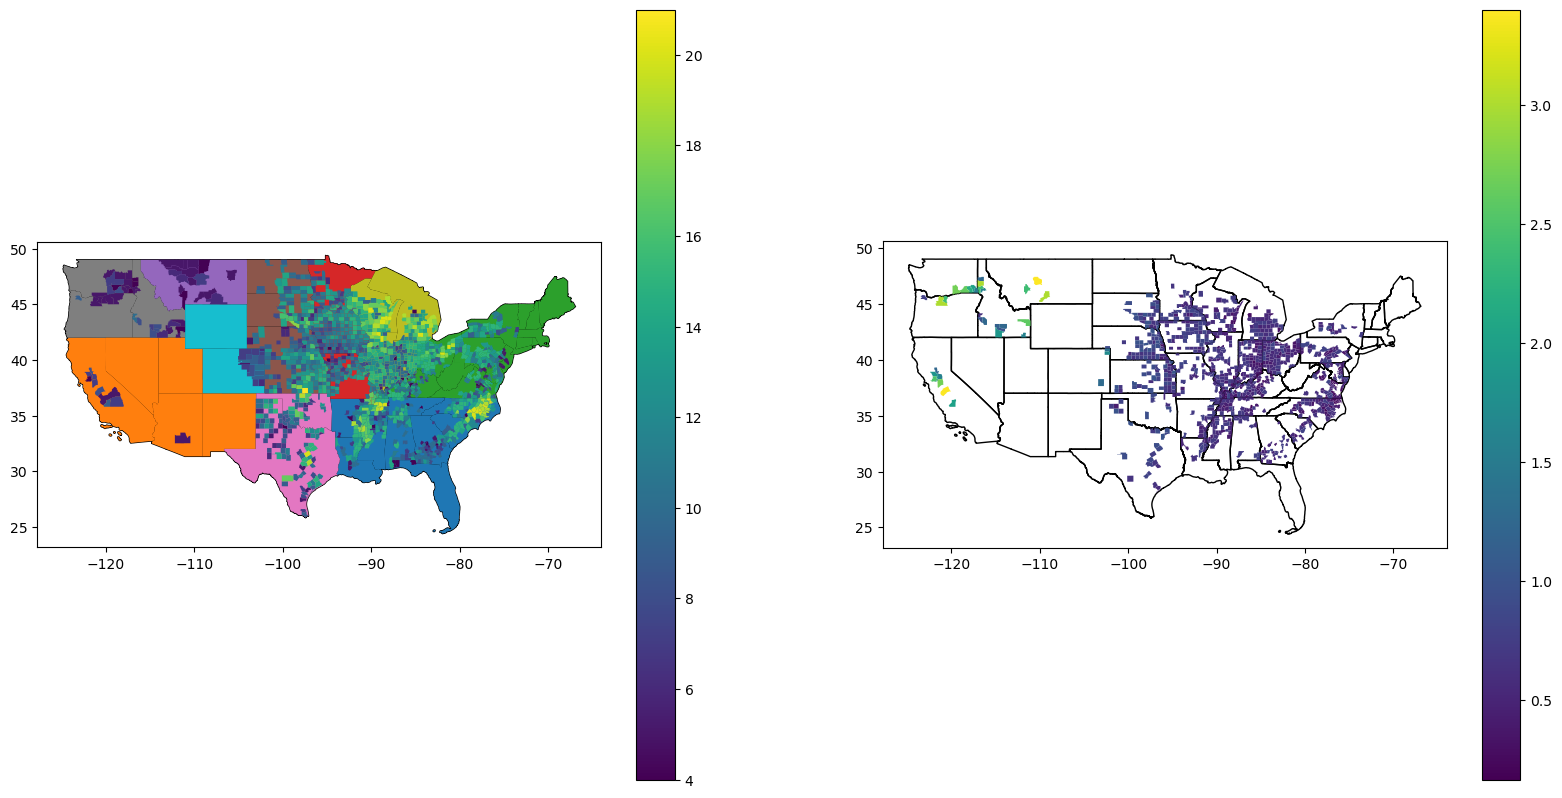

In [23]:
rm_co = 1000 # number of counties to remove
gdf['CID'] = gdf['GEOID'].apply(lambda x: x[:2])
gdf2 = gdf.copy()
# sort according to state groups
for i, g in enumerate(state_groups):
    gdf2['CID'] = gdf2['CID'].apply(lambda x: state_groups[i][0] if x in g else x)
    states['STATEFP'] = states['STATEFP'].apply(lambda x: state_groups[i][0] if x in g else x)

# minimum number of counties per state is defined by original number of counties
min_cos = [int(len(gdf2[gdf2['CID'].isin(g)])*.2) for g in state_groups]
min_cos[0] = 7
min_cos[1] = 20
min_cos[2] = min_cos[2]*2
min_cos[4] = int(min_cos[4]*1.5)

# mark the worst counties
gdf2 = gdf2.sort_values('metric')
gdf2['rm'] = False
gdf2.iloc[-rm_co:, gdf2.columns.get_loc('rm')] = True

gdfg = gdf2.groupby('CID')
# remove the marked counties, when enough counties are available
for i, min_co in zip(range(len(gdfg)), min_cos):
    group = gdfg.get_group(state_groups[i][0])
    if len(group.index) < min_co:
        continue
    group = group.sort_values('metric')
    group = group[group['rm'] == True]
    rm_co2 = len(group.index)
    if len(group.index) - rm_co < min_co:
        rm_co2 = len(group.index) - min_co
    if rm_co2 < 1:
        continue
    worst = group.iloc[-rm_co2:]['GEOID']
    # rm worst
    gdf2 = gdf2[~gdf2['GEOID'].isin(worst)]

fig, ax = plt.subplots(1,2, figsize=(20,10))
# show final selection
states.plot(ax=ax[0], facecolor='None', edgecolor='black')
states.plot(ax=ax[0], column='STATEFP')
gdf.plot(ax=ax[0], column='Total_Count', legend=True)
states.plot(ax=ax[1], facecolor='None', edgecolor='black')
gdf2.plot(ax=ax[1], column='metric', legend=True)
plt.show()

In [ ]:
# save it to a csv
gdf2.to_file(os.path.join(data_dir, 'county_list_tiny.geojson'))